In [1]:
#Survey Alphafold PLDDT scores and plot by orthogroup.  
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
from collections import Counter
%load_ext autoreload
%autoreload 2
import diverse_yeast_tools as dyt

import json

base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts/alphafold')


y1000plus_dir = os.path.normpath('C:/Users/bheineike/Documents/GitHub/y1000plus_tools') + os.sep

#Load y1000 species table
y1000_species = pd.read_csv(y1000plus_dir + os.path.normpath("y1000plus_tools_data/y1000plus/y1000_species_table.csv"), index_col=0)

#fig2_orig_genome_lookup = dict(zip(y1000_species['species_names_fig2'], y1000_species['original_genome_id']))
orig_genome_lookup = dict(zip(y1000_species['original_genome_id'],y1000_species['old_species_names']))

with open(base_dir + os.sep + 'selected_proteins' + os.sep + 'og_metadata.json', 'r') as f:
    og_metadata = json.load(f)



In [2]:
score_table = pd.read_table(base_dir + os.sep + 'selected_proteins' + os.sep + 'structure_calcs' + os.sep +  'selected_proteins_progress.tsv')

In [3]:
new_score = []
for score in score_table['Plddt']:
    if score == '-': 
        new_score.append(0)
    else:
        new_score.append(float(score))
        
score_table['Plddt_0_rep'] = new_score

In [4]:
#Add name from the sequence MSAs
seq_aln_names = []
for name in score_table['ID']:
    (old_name, og, y1000_id) = name.split('__')
    seq_aln_names.append(orig_genome_lookup[old_name] + '|' + y1000_id)

score_table['ID_seq_aln'] = seq_aln_names


In [ ]:
#Filter out sequences from score table that were part of orthogroups that failed the species filter.

In [13]:
filtered_ogs = []
for og, metadata in og_metadata.items(): 
    if not(metadata['pass_species_filter']):
        filtered_ogs.append(og)
        

score_table_filtered = score_table[score_table['OG'].isin(set(score_table['OG'])-set(filtered_ogs))]

In [19]:
print('attempted to predict a total of {} (excluding those from filtered out orthogroups)'.format(len(score_table_filtered))) 

print('{} sequences could not be predicted'.format(sum(score_table_filtered['Plddt_0_rep']==0)))


attempted to predict a total of 10545 (excluding those from filtered out orthogroups)
577 sequences could not be predicted


Text(0.5, 1.0, 'Histogram of PLDDT Scores for Calculated Structures')

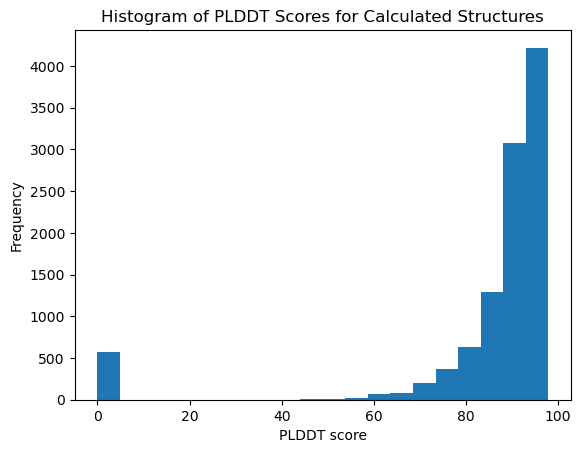

In [21]:
fig, ax = plt.subplots()

ax.hist(score_table_filtered['Plddt_0_rep'], bins = 20)
ax.set_xlabel('PLDDT score')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of PLDDT Scores for Calculated Structures')

In [32]:
peptides_calculated

,ID,species,OG,Plddt,Plddt_0_rep,ID_seq_aln
0,alloascoidea_hylecoeti__OG1004__0_1963,alloascoidea,OG1004,79.9559,79.9559,Alloascoidea_hylecoeti|0_1963
1,alloascoidea_hylecoeti__OG1004__0_887,alloascoidea,OG1004,69.6685,69.6685,Alloascoidea_hylecoeti|0_887
2,alloascoidea_hylecoeti__OG1004__0_8918,alloascoidea,OG1004,75.0749,75.0749,Alloascoidea_hylecoeti|0_8918
3,alloascoidea_hylecoeti__OG1004__0_9006,alloascoidea,OG1004,74.7122,74.7122,Alloascoidea_hylecoeti|0_9006
4,alloascoidea_hylecoeti__OG1004__0_9052,alloascoidea,OG1004,85.0866,85.0866,Alloascoidea_hylecoeti|0_9052
...,...,...,...,...,...,...
10012,kluyveromyces_lactis__OG5735__50_1861,kluyveromyces,OG5735,86.8511,86.8511,Kluyveromyces_lactis|50_1861
10013,kluyveromyces_marxianus__OG5735__51_3408,kluyveromyces,OG5735,87.0479,87.0479,Kluyveromyces_marxianus|51_3408
10014,lachancea_thermotolerans__OG5735__64_2434,lachancea,OG5735,85.6473,85.6473,Lachancea_thermotolerans|64_2434
10015,vanderwaltozyma_polyspora__OG5735__136_2007,vanderwaltozyma,OG5735,85.8323,85.8323,Vanderwaltozyma_polyspora|136_2007


In [40]:
#For each OG, for the peptides that are calculated, calculate Mean and Var

#Scatter of Mean vs Var of PLDDT score, with color as percentage that is not calculate

peptides_calculated = score_table_filtered.loc[score_table_filtered['Plddt_0_rep']>0,:].copy()
peptides_calculated_grouped = peptides_calculated.loc[:,['OG','Plddt_0_rep']].groupby('OG')
peptides_not_calculated = score_table_filtered.loc[score_table_filtered['Plddt_0_rep']==0,:].copy()
print(str(len(peptides_not_calculated)) + ' structures that could not be calculated')

all_og_counts = Counter(score_table_filtered['OG'])
og_blank_counts = Counter(peptides_not_calculated['OG'])

og_plddt_dict = {}

for og in list(set(score_table_filtered['OG'])):
    #(plddt_mean, plddt_var, N_tot, N_not_calc, pct_not_calc, sc_names, pathway_name)
    if og in set(peptides_calculated['OG']):
        plddt_mean = peptides_calculated_grouped.mean().loc[og,'Plddt_0_rep']
        plddt_std = peptides_calculated_grouped.std().loc[og,'Plddt_0_rep']
    else:
        plddt_mean = 0
        plddt_std = 0
    
    N_tot = all_og_counts[og]
    if og in og_blank_counts.keys(): 
        N_not_calc = og_blank_counts[og]
    else: 
        N_not_calc = 0
    pct_not_calc = N_not_calc/N_tot
    sc_names = og_metadata[og]['sc_names']
    pathway_name = og_metadata[og]['pathways_name']
    
    og_plddt_dict[og] = (plddt_mean, plddt_std, N_tot, N_not_calc, pct_not_calc, sc_names, pathway_name)
    

og_plddt_table = pd.DataFrame.from_dict(og_plddt_dict, orient = 'index', columns = ['plddt_mean', 'plddt_std', 'N_tot', 'N_not_calc', 'pct_not_calc', 'sc_names', 'pathway_name'])

og_plddt_table.sort_values('pct_not_calc', ascending=False, inplace=True)


577 structures that could not be calculated


In [123]:
og_plddt_table.to_csv(base_dir + os.sep + 'selected_proteins' + os.sep + 'structure_calcs' + os.sep +  'og_plddt_data.csv')

In [132]:
#Orthogroup distribution of uncalculated structures

og_plddt_table[og_plddt_table['pct_not_calc']>0.5]


og_plddt_table[ (og_plddt_table['N_not_calc']>0 ) & (og_plddt_table['N_not_calc']<=3 )]

pct_thresh = 0.5

top_ogs_not_calc = og_plddt_table[og_plddt_table['pct_not_calc']>pct_thresh]

print("{:2.1%} of uncalculated structures were in the {} orthogroups with more than {:2.0%} of thir structures uncalculated".format(
    sum(top_ogs_not_calc['N_not_calc'])/len(peptides_not_calculated), 
    len(top_ogs_not_calc), 
    pct_thresh
    ))



29.3% of uncalculated structures were in the 7 orthogroups with more than 50% of thir structures uncalculated


Text(0, 0.5, 'Std of Plddt for OG')

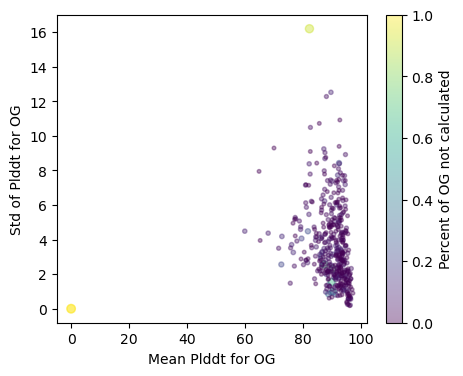

In [42]:
fig, ax = plt.subplots(figsize = (5,4))

im = ax.scatter(og_plddt_table['plddt_mean'], og_plddt_table['plddt_std'], alpha = 0.4, c = og_plddt_table['pct_not_calc'], s = 30*og_plddt_table['pct_not_calc'] + 7 )
fig.colorbar(im, ax=ax, label = 'Percent of OG not calculated')
ax.set_xlabel('Mean Plddt for OG')
ax.set_ylabel('Std of Plddt for OG')


In [43]:
peptides_not_calculated.sort_values('OG', inplace=True)

In [45]:
#Add Uniprot Names and lengths to Peptides not calculated

#can use 'selected_protein_ids.json'

#Load original sequence file, and make dictionary of gene_id to fasta header and gene_id to peptide sequence
#Read in Sequence File, extract all names make dict of seq_alignment sequences
selected_proteins = SeqIO.parse(base_dir +os.sep +'selected_proteins' + os.sep +   'selected_proteins.fasta', 'fasta')
selected_proteins_headers = {}
selected_proteins_seqs = {}
for record in selected_proteins: 
    selected_proteins_headers[record.id] = record.description
    selected_proteins_seqs[record.id] = str(record.seq)

# #Load peptide sequences for model species, make dictionary from gene id to peptide sequence
# model_protein_dict = {}
# for spec_abbrev in ['Scer', 'Spom', 'Calb']: 
#     model_protein_dict[spec_abbrev] = dyt.load_model_protein_dict(spec_abbrev)
    

In [46]:
uniprot_id = []
seq_len = []
for ind, (name_orig, spec_table, og, plddt, plddt_0_rep, id_seq_aln) in peptides_not_calculated.iterrows():
#     structure_imported=False
#     #Check if name in ref sequence (S.cer, C.alb, and S. pom) + convert
#     if name_orig.split('_')[0] in set(['Scer', 'REF', 'Calb', 'Spom']):
#         structure_imported = True
#         if name_orig.split('_')[0] == 'REF': 
#             spec_abbrev = name_orig.split('_')[1]
#             swissprot_id = name_orig.split('_')[2].split('-')[1]
#         else: 
#             spec_abbrev = name_orig.split('_')[0]
#             swissprot_id = name_orig.split('_')[1].split('-')[1]

#         (spec) = modelspec_params[spec_abbrev]
#         gene_id = swissprot_id_2_gene_id[spec_abbrev][swissprot_id]
#         if spec_abbrev == 'Spom':
#             y1000_id = 'None'
#         else: 
#             #spec_old = spec_abbrev_dict[spec_abbrev]
#             y1000_id = gene_id_2_y1000_id[spec_abbrev][gene_id]

#     else: 
    
    (spec, og, y1000_id) = name_orig.split('__')


    #Filter by structural clusters within OGs based on Nir's analysis
    #if name_orig in seqs_to_include: 

    #Extract sequence from original peptide fasta

#     if structure_imported: 
#         prot_seq = model_protein_dict[spec_abbrev][gene_id]
#         L = len(prot_seq)
#         #header = '>' + name_orig + ' source=af2  gene_full=' + gene_id +' y1000_id=' + y1000_id + ' L=' + str(L) + '\n' 

#         #proteins_present_by_spec[spec].append((name_orig,gene_id,y1000_id,swissprot_id,'af2'))


#     else: 
    header_dict = {}
    header_raw =selected_proteins_headers[name_orig] 
    for item in header_raw.split(' ')[1:]: 
        key,val = item.split('=')
        header_dict[key] = val

    source = header_dict['source']
    if source=='uniprot':
        swissprot_id = header_dict['gene_full'].split('|')[1]
    elif source=='shen':
        swissprot_id = None

    #proteins_present_by_spec[spec].append((name_orig,None,y1000_id,swissprot_id, source))

    prot_seq = selected_proteins_seqs[name_orig]
    L = len(prot_seq)
    #header = '>' + header_raw + '\n'  

    uniprot_id.append(swissprot_id)
    seq_len.append(L)

peptides_not_calculated['seq_len'] = seq_len
peptides_not_calculated['uniprot_id'] = uniprot_id

In [50]:
#og_plddt_table.to_csv(base_dir + os.sep + 'alphafold' + os.sep + 'og_plddt_data.csv')
peptides_not_calculated.to_csv(base_dir + os.sep + 'selected_proteins' + os.sep + 'structure_calcs' + os.sep +  'failed_structures.csv')

In [56]:
uniprot_id = []
seq_len = []
for ind, (name_orig, spec_table, og, plddt, plddt_0_rep, id_seq_aln) in peptides_calculated.iterrows():
#     structure_imported=False
#     #Check if name in ref sequence (S.cer, C.alb, and S. pom) + convert
#     if name_orig.split('_')[0] in set(['Scer', 'REF', 'Calb', 'Spom']):
#         structure_imported = True
#         if name_orig.split('_')[0] == 'REF': 
#             spec_abbrev = name_orig.split('_')[1]
#             swissprot_id = name_orig.split('_')[2].split('-')[1]
#         else: 
#             spec_abbrev = name_orig.split('_')[0]
#             swissprot_id = name_orig.split('_')[1].split('-')[1]

#         (spec) = modelspec_params[spec_abbrev]
#         gene_id = swissprot_id_2_gene_id[spec_abbrev][swissprot_id]
#         if spec_abbrev == 'Spom':
#             y1000_id = 'None'
#         else: 
#             #spec_old = spec_abbrev_dict[spec_abbrev]
#             y1000_id = gene_id_2_y1000_id[spec_abbrev][gene_id]

#     else: 
    
    (spec, og, y1000_id) = name_orig.split('__')


    #Filter by structural clusters within OGs based on Nir's analysis
    #if name_orig in seqs_to_include: 

    #Extract sequence from original peptide fasta

#     if structure_imported: 
#         prot_seq = model_protein_dict[spec_abbrev][gene_id]
#         L = len(prot_seq)
#         #header = '>' + name_orig + ' source=af2  gene_full=' + gene_id +' y1000_id=' + y1000_id + ' L=' + str(L) + '\n' 

#         #proteins_present_by_spec[spec].append((name_orig,gene_id,y1000_id,swissprot_id,'af2'))


#     else: 
    header_dict = {}
    header_raw =selected_proteins_headers[name_orig] 
    for item in header_raw.split(' ')[1:]: 
        key,val = item.split('=')
        header_dict[key] = val

    source = header_dict['source']
    if source=='uniprot':
        swissprot_id = header_dict['gene_full'].split('|')[1]
    elif source=='shen':
        swissprot_id = None

    #proteins_present_by_spec[spec].append((name_orig,None,y1000_id,swissprot_id, source))

    prot_seq = selected_proteins_seqs[name_orig]
    L = len(prot_seq)
    #header = '>' + header_raw + '\n'  

    uniprot_id.append(swissprot_id)
    seq_len.append(L)

peptides_calculated['seq_len'] = seq_len
peptides_calculated['uniprot_id'] = uniprot_id

In [87]:
#og_plddt_table.to_csv(base_dir + os.sep + 'alphafold' + os.sep + 'og_plddt_data.csv')
peptides_calculated.to_csv(base_dir + os.sep + 'selected_proteins' + os.sep + 'structure_calcs' + os.sep +  'predicted_structures.csv')

In [121]:
#Species enrichment for uncalculated structures
spec_dist_uncalculated = Counter(peptides_not_calculated['species'])
print(spec_dist_uncalculated)

worst_predicted_specs = {'H. osmophilia': 'yHMPu5000034957', 
                         'Z. rouxii': 'zygosaccharomyces',
                         'Y. lipolytica': 'yarrowia'
                        }

print("{:2.1%} of the unpredicted structures were in {}, {} and {}".format(*([ ((spec_dist_uncalculated['yHMPu5000034957'] + spec_dist_uncalculated['zygosaccharomyces'] + spec_dist_uncalculated['yarrowia']) / len(peptides_not_calculated))] + list(worst_predicted_specs.keys()))))

Counter({'yHMPu5000034957': 163, 'zygosaccharomyces': 131, 'yarrowia': 48, 'kazachstania': 30, 'cyberlindnera': 19, 'alloascoidea': 17, 'ogataea': 16, 'candida': 16, 'torulaspora': 14, 'ascoidea': 14, 'geotrichum': 13, 'eremothecium': 12, 'wickerhamomyces': 12, 'kluyveromyces': 11, 'vanderwaltozyma': 11, 'debaryomyces': 10, 'yHMPu5000034604': 8, 'komagataella': 8, 'tortispora': 7, 'lipomyces': 6, 'lachancea': 6, 'pachysolen': 5})
59.3% of the unpredicted structures were in H. osmophilia, Z. rouxii and Y. lipolytica


20.8% of the non-calculated peptides had a sequence length greater than 1800
0.6% of the non-calculated peptides had a sequence length greater than 1800
5.0% of the non-calculated peptides had a sequence length greater than 1800
55.6% of the non-calculated peptides had a sequence length greater than 1800


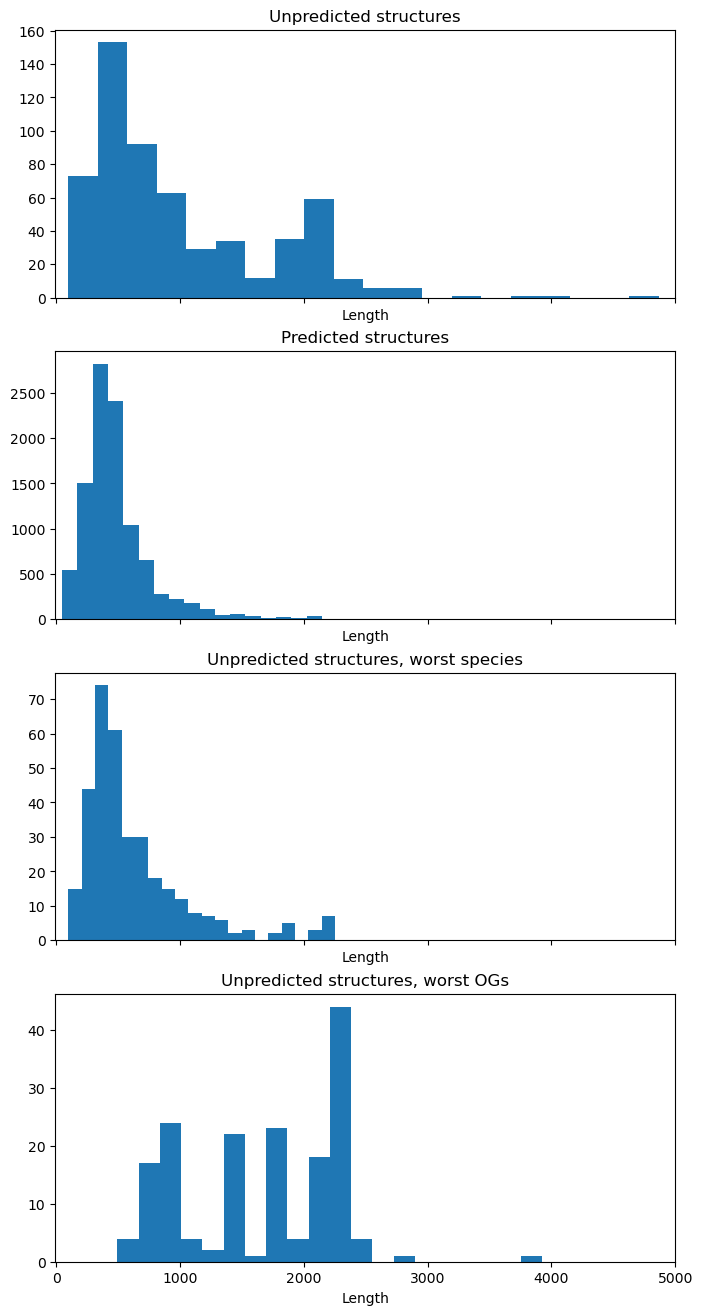

In [139]:
#Length distribution of failed structures

fix, axarr = plt.subplots(4,1, sharex=True, figsize = (8,16)) 

length_thresh = 1800

worst_predicted_specs = {'H. osmophilia': 'yHMPu5000034957', 
                         'Z. rouxii': 'zygosaccharomyces',
                         'Y. lipolytica': 'yarrowia'
                        }

datasets = {'Unpredicted structures': peptides_not_calculated, 
            'Predicted structures': peptides_calculated,
            'Unpredicted structures, worst species': peptides_not_calculated[peptides_not_calculated['species'].isin(set(worst_predicted_specs.values()))],
            'Unpredicted structures, worst OGs': peptides_not_calculated[peptides_not_calculated['OG'].isin(top_ogs_not_calc.index)]
           }

for jj,(dataset_id, data) in enumerate(datasets.items()): 

    ax = axarr[jj] 
    
    ax.hist(data['seq_len'], bins=20) 
    ax.set_xlim([-10,5000])
    ax.set_xlabel('Length')
    ax.set_title(dataset_id)
    
    print("{:2.1%} of the non-calculated peptides had a sequence length greater than {}".format(sum(data['seq_len']>length_thresh)/len(data), length_thresh))

    
fig.tight_layout()


Text(0, 0.5, 'PLDDT')

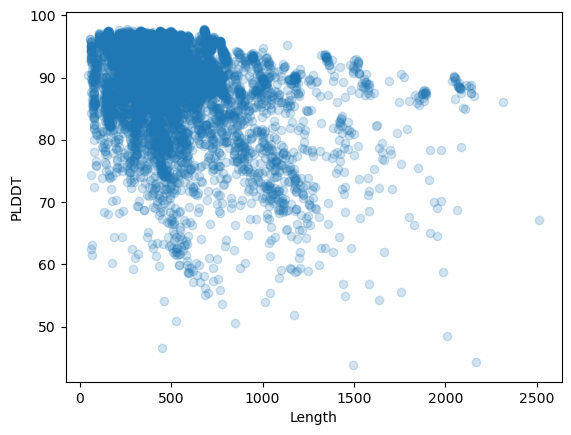

In [85]:
fig, ax = plt.subplots()

ax.scatter(peptides_calculated['seq_len'], peptides_calculated['Plddt_0_rep'], alpha = 0.2)

ax.set_xlabel('Length')
ax.set_ylabel('PLDDT')

In [174]:
#How many uncalculated peptides in the top 7 orthogroups, top 3 species, or have length greater than 1800? 

peptides_not_calc_remainder = set(peptides_not_calculated.index) - set(peptides_not_calculated[peptides_not_calculated['OG'].isin(top_ogs_not_calc.index)].index)

peptides_not_calc_remainder = set(peptides_not_calc_remainder) - set(peptides_not_calculated[peptides_not_calculated['species'].isin(set(worst_predicted_specs.values()))].index)

peptides_not_calc_remainder = set(peptides_not_calc_remainder) -   set(peptides_not_calculated[peptides_not_calculated['seq_len']>length_thresh].index)
                                                        
                                                                                         
"{:2.1%} of uncalculated peptides not in worst 3 species, worst 3 orthogroups, or have length greater than 1800.".format(len(peptides_not_calculated.loc[list(peptides_not_calc_remainder),:])/len(peptides_not_calculated))




'11.6% of uncalculated peptides not in worst 3 species, worst 3 orthogroups, or have length greater than 1800.'

In [182]:
print("{} of the uncalculated peptides have uniprot IDs.  This is only from those sequences which I obtained from uniprot which only includes the 9 we did experiments on.  Even then some sequences I got from shen et al, as there was not a good enough match to the uniprot protein sequences".format(sum(~peptides_not_calculated['uniprot_id'].isna())))

335 of the uncalculated peptides have uniprot IDs.  This is only from those sequences which I obtained from uniprot which only includes the 9 we did experiments on.  Even then some sequences I got from shen et al, as there was not a good enough match to the uniprot protein sequences


In [140]:
#Check Nir's downloaded structures to see how much those overlap with the peptides not calculated

alphafold_download_list = os.path.normpath( base_dir + '/selected_proteins/structure_calcs/missing_p1/missing_prots_in_alphafold.txt')


n_line_w_data = 0

og_list = []
spec_list = []
pdb_list = []

download_data = {0: og_list, 
                 1: spec_list, 
                 2: pdb_list
                }


with open(alphafold_download_list) as f_in: 
    for line in f_in.readlines():
        #print(line)
        if line != '\n': 
            col = np.mod(n_line_w_data, 3)           
            
            download_data[col].append(line.strip())
            
            n_line_w_data = n_line_w_data + 1
        
download_data_df = pd.DataFrame(download_data)
download_data_df.columns = ['og','species', 'pdb_id']

#The exact ID of the sequence was lost - Nir might have it.  could go from the file directly like this 

# for jj, (dirname, subdirs, files) in os.walk(os.path.normpath(base_dir + '/selected_proteins/structure_calcs/missing_p1/missing_prots_in_alphafold')): 
#     if jj==0: 
#         og_list = subdirs
#     else:  

        

In [143]:
download_data_df

,og,species,pdb_id
0,OG1012,Zygosaccharomyces_rouxii,C5DTN7
1,OG1012,Zygosaccharomyces_rouxii,C5DPK1
2,OG1016,Zygosaccharomyces_rouxii,C5DZD3
3,OG1016,Zygosaccharomyces_rouxii,C5DTZ6
4,OG1021,Zygosaccharomyces_rouxii,C5DTH7
...,...,...,...
164,OG6290,Zygosaccharomyces_rouxii,C5DXP0
165,OG6574,Zygosaccharomyces_rouxii,C5DSS7
166,OG6598,Zygosaccharomyces_rouxii,C5DUP9
167,OG7278,Zygosaccharomyces_rouxii,C5DPJ8


# Make list of missing structures and structures with errors for Sandra to recalculate

In [27]:
#Proteins not calculated

structure_calcs_base_dir = base_dir + os.sep + 'selected_proteins' + os.sep + 'structure_calcs' 

all_proteins_fname = base_dir + os.sep + os.path.normpath('selected_proteins/all_proteins.fasta')

proteins_not_calculated_fname = structure_calcs_base_dir + os.sep +  'failed_structures.csv'

proteins_not_calculated = pd.read_csv(proteins_not_calculated_fname, index_col=0)

print(str(len(proteins_not_calculated)) + ' predicted structures not calculated')

proteins_not_calculated_fasta_fname = structure_calcs_base_dir + os.sep +  'proteins_not_calculated.fasta'

all_proteins = SeqIO.parse(all_proteins_fname, 'fasta')


with open(proteins_not_calculated_fasta_fname, 'w') as f_out: 
    counter = 0
    for record in all_proteins: 
        if record.id in set(proteins_not_calculated['ID']):
            counter=counter+1
            f_out.write('>' + record.id + '\n')
            f_out.write(str(record.seq) + '\n')

print('fasta contains ' + str(counter) + ' sequences')


577 predicted structures not calculated
fasta contains 577 sequences


In [34]:
#structures with errors with errors: 

structures_with_errors_fasta_fname =  structure_calcs_base_dir + os.sep +  'structures_with_errors.fasta'

structures_with_errors_list_fname = structure_calcs_base_dir + os.sep + 'structures_with_errors.txt'

structures_with_errors_list = []
with open(structures_with_errors_list_fname,'r') as f_in: 
    for line in f_in.readlines():
        structures_with_errors_list.append(line.strip().split('.')[0])

print( str(len(structures_with_errors_list)) + ' structures with errors per Nir')

all_proteins = SeqIO.parse(all_proteins_fname, 'fasta')
structures_with_errors_found = []
with open(structures_with_errors_fasta_fname, 'w') as f_out: 
    counter = 0
    for record in all_proteins: 
        if record.id in set(structures_with_errors_list):
            counter=counter+1
            f_out.write('>' + record.id + ' L=' + str(len(str(record.seq))) + '\n')
            f_out.write(str(record.seq) + '\n')
            structures_with_errors_found.append(record.id)

print('fasta contains ' + str(counter) + ' sequences')


51 structures with errors per Nir
fasta contains 50 sequences


In [32]:
#One S. pombe structure had an Error in Nir's list - this would have been in the original alphafold database. 

set(structures_with_errors_list) - set(structures_with_errors_found)


{'Spom_AF-P87241-F1-model_v2'}